In [11]:
NAME = 'base-tabiturient'

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf
import keras

from tensorflow.keras import layers
from tensorflow.keras import losses

import matplotlib.pyplot as plt

2024-06-08 12:07:35.483096: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import datetime

In [3]:
import mydata as md

data = md.Data('cache')


In [4]:
raw_train_ds, raw_valid_ds, raw_test_ds = data.load('tabiturient')

In [5]:
max_features = 20000
sequence_length = 1000

vectorize_layer = keras.layers.TextVectorization(
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length
)

In [6]:
vectorize_layer.adapt(raw_train_ds.map(lambda x,y: x))

2024-06-08 12:07:59.323006: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [7]:
train_ds = data.vectorize(raw_train_ds, vectorize_layer)
valid_ds = data.vectorize(raw_valid_ds, vectorize_layer)
test_ds = data.vectorize(raw_test_ds, vectorize_layer)


In [8]:
train_ds_batch=train_ds.shuffle(len(train_ds), reshuffle_each_iteration=True).batch(64)
valid_ds_batch=valid_ds.batch(64)
test_ds_batch=test_ds.batch(64)


In [9]:
embedding_dim=64

embedding_layer = tf.keras.layers.Embedding(
    input_dim=(max_features),
    output_dim=embedding_dim,
    mask_zero=True
)

model = tf.keras.Sequential([
    keras.Input(shape=(None,), dtype="int64"),
    embedding_layer,
    tf.keras.layers.GlobalMaxPool1D(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=None),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(3, kernel_regularizer=None)
])
model.summary()

model.compile(loss=losses.CategoricalCrossentropy(from_logits=True),
              optimizer='rmsprop',
              metrics=['accuracy', tf.keras.metrics.F1Score(average='macro')])

/home/alex/ai_venv_2/lib/python3.12/site-packages/keras/src/layers/layer.py:881: UserWarning: Layer 'global_max_pooling1d' (of type GlobalMaxPooling1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, None, 64)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 64)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,284,355 (4.90 MB)

 Trainable params: 1,284,355 (4.90 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
checkpoint_filepath = f"models/checkpoint_{NAME}.weights.h5"

log_dir = f"logs/fit-{NAME}/{datetime.datetime.now().strftime("%Y-%m-%d %H-%M-%S")}"

epochs = 15
history = model.fit(
    train_ds_batch,
    validation_data=valid_ds_batch,
    epochs=epochs,
    callbacks = [
        keras.callbacks.ModelCheckpoint(
            filepath=checkpoint_filepath,
            monitor='val_accuracy',
            mode='max',
            save_weights_only=True,
            save_best_only=True
        ),
        tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
    ]
)

Epoch 1/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.4548 - f1_score: 0.2819 - loss: 1.0622

2024-06-08 12:08:50.847976: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 307200000 exceeds 10% of free system memory.


45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 78ms/step - accuracy: 0.4554 - f1_score: 0.2814 - loss: 1.0619 - val_accuracy: 0.5181 - val_f1_score: 0.2275 - val_loss: 1.0034
Epoch 2/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.4972 - f1_score: 0.2318 - loss: 1.0345

2024-06-08 12:08:55.174875: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 307200000 exceeds 10% of free system memory.


45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - accuracy: 0.4971 - f1_score: 0.2318 - loss: 1.0345 - val_accuracy: 0.5181 - val_f1_score: 0.2275 - val_loss: 0.9976
Epoch 3/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.5007 - f1_score: 0.2269 - loss: 1.0235

2024-06-08 12:08:59.459875: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 307200000 exceeds 10% of free system memory.


45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - accuracy: 0.5006 - f1_score: 0.2269 - loss: 1.0236 - val_accuracy: 0.5181 - val_f1_score: 0.2275 - val_loss: 0.9908
Epoch 4/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.4979 - f1_score: 0.2354 - loss: 1.0254

2024-06-08 12:09:03.994714: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 307200000 exceeds 10% of free system memory.


45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - accuracy: 0.4980 - f1_score: 0.2356 - loss: 1.0252 - val_accuracy: 0.5181 - val_f1_score: 0.2275 - val_loss: 0.9745
Epoch 5/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.5175 - f1_score: 0.2687 - loss: 0.9984

2024-06-08 12:09:08.394448: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 307200000 exceeds 10% of free system memory.


45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - accuracy: 0.5175 - f1_score: 0.2689 - loss: 0.9986 - val_accuracy: 0.5320 - val_f1_score: 0.2618 - val_loss: 0.9534
Epoch 6/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - accuracy: 0.5257 - f1_score: 0.3174 - loss: 0.9964 - val_accuracy: 0.5543 - val_f1_score: 0.3039 - val_loss: 0.9254
Epoch 7/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - accuracy: 0.5390 - f1_score: 0.3418 - loss: 0.9802 - val_accuracy: 0.6184 - val_f1_score: 0.4062 - val_loss: 0.9012
Epoch 8/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - accuracy: 0.5918 - f1_score: 0.4038 - loss: 0.9265 - val_accuracy: 0.6546 - val_f1_score: 0.4485 - val_loss: 0.8752
Epoch 9/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - accuracy: 0.5975 - f1_score: 0.4218 - loss: 0.9322 - val_accuracy: 0.6992 - val_f1_score: 0.4953 - val_loss: 0.8412
Epoch 10/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - accuracy: 0.6139 - f1_score: 0.4381 - loss: 0.9092 - val_accuracy: 0.7159 - val_f1_score: 0.5089 - val_loss: 0.8

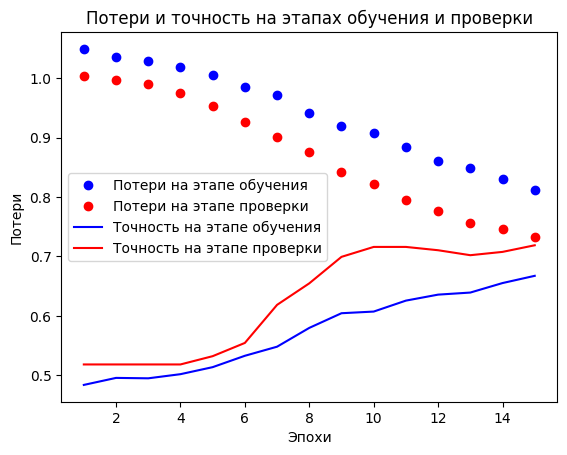

In [13]:
data.plot(history)

In [14]:
model.load_weights(checkpoint_filepath)

In [15]:
model.evaluate(test_ds_batch)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6998 - f1_score: 0.5040 - loss: 0.7657


[0.768186092376709, 0.699999988079071, 0.5052306652069092]

In [16]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  tf.keras.layers.Activation('softmax')
])

export_model.compile(
    loss=losses.CategoricalCrossentropy(from_logits=False), optimizer="rmsprop", metrics=['accuracy', 'F1Score']
)

export_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ ?                      │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ ?                      │     1,284,355 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,284,355 (4.90 MB)

 Trainable params: 1,284,355 (4.90 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
export_model.save(f"models/export-model-{NAME}.keras")

/home/alex/ai_venv_2/lib/python3.12/site-packages/keras/src/saving/saving_api.py:100: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  saving_lib.save_model(model, filepath)
